<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [3]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [4]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-02-18 09:35:11--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-02-18 09:35:11 (12.7 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [5]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [6]:
df.shape

(346, 10)

### Convert to date time object 

In [7]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [8]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [9]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1              |       h7b6447c_0         5.0 MB  anaconda
    seaborn-0.10.0             |             py_0         161 KB  anaconda
    certifi-2019.11.28         |           py36_0         156 KB  anaconda
    ca-certificates-2020.1.1   |                0         132 KB  anaconda
    ------------------------------------------------------------
                                           Total:         5.5 MB

The following packages will be UPDATED:

    ca-certificates: 2019.11.27-0       --> 2020.1.1-0        anaconda
    certifi:         2019.11.28-py36_0  --> 2019.11.28-py36_0 anaconda
    openssl:         1.1.1d-h7b6447c_3  --> 1.1.1-h7b6447c_0  anaconda
    seaborn:         0.9.0-pyh91

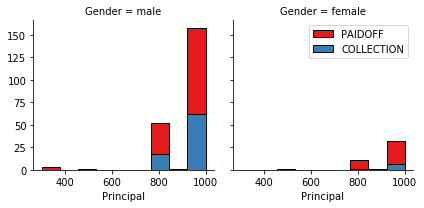

In [10]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

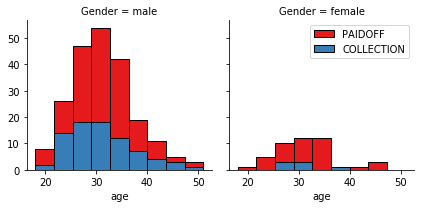

In [11]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

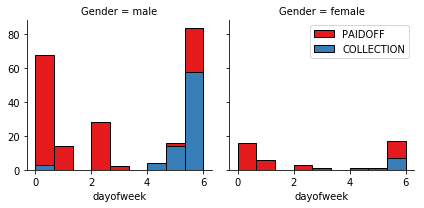

In [12]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [13]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [14]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [15]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [16]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [17]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [18]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [19]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [20]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [21]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (242, 8) (242,)
Test set: (104, 8) (104,)


In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Kvalues = 20
mean = np.zeros((Kvalues-1))
std = np.zeros((Kvalues-1))

print("\n", std)
print("\n", mean)


for n in range(1,Kvalues):
    
    #clasification model and accuracy 
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean[n-1] = metrics.accuracy_score(y_test, yhat)
    
    std[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

print("\n", std)
print("\n", mean)
print( "\nThe best accuracy is with: %.3f" % mean.max()) 
print( "\nThe best K value is with: ", (mean.argmax()+1)) 


 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

 [0.04525757 0.04599795 0.04131432 0.04525757 0.04299097 0.045639
 0.04299097 0.04599795 0.04246039 0.04397234 0.04004684 0.04397234
 0.04069644 0.04246039 0.04131432 0.04190188 0.04069644 0.04131432
 0.04069644]

 [0.69230769 0.67307692 0.76923077 0.69230769 0.74038462 0.68269231
 0.74038462 0.67307692 0.75       0.72115385 0.78846154 0.72115385
 0.77884615 0.75       0.76923077 0.75961538 0.77884615 0.76923077
 0.77884615]

The best accuracy is with: 0.788

The best K value is with:  11


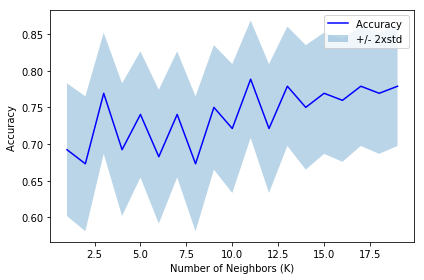

In [25]:
plt.plot(range(1,Kvalues),mean,'b')
plt.fill_between(range(1,Kvalues),mean - 2 * std, mean + 2 * std, alpha=0.3)
plt.legend(('Accuracy ', '+/- 2xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

# Decision Tree

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=1)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (259, 8) (259,)
Test set: (87, 8) (87,)


In [27]:
from sklearn.tree import DecisionTreeClassifier

loan_status = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

loan_status.fit(X_train, y_train)

prediction= loan_status.predict(X_test)
print("\nPrediction Tree: ",prediction[0:10])
print("\nTest set: ", y_test[0:10])

from sklearn import metrics
print("\nDecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, prediction))


Prediction Tree:  ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']

Test set:  ['COLLECTION' 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'COLLECTION'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']

DecisionTrees's Accuracy:  0.7471264367816092


In [28]:
my_data= pd.read_csv('loan_train.csv')
my_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'loan_status', 'Principal', 'terms',
       'effective_date', 'due_date', 'age', 'education', 'Gender'],
      dtype='object')

In [29]:
# installing pydotplus package for visulization

!conda install pydotplus

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.1.1   |                0         132 KB
    pydotplus-2.0.2            |             py_1          23 KB
    openssl-1.1.1d             |       h7b6447c_4         3.7 MB
    certifi-2019.11.28         |           py36_0         156 KB
    ------------------------------------------------------------
                                           Total:         4.1 MB

The following NEW packages will be INSTALLED:

    pydotplus:       2.0.2-py_1                

The following packages will be UPDATED:

    ca-certificates: 2020.1.1-0        anaconda --> 2020.1.1-0       
    certifi:         2019.11.28-py36_0 anaconda --> 2019.11.28-py36_0

The following packages will be DOWNGRADED:

  

   Social Group  Wealhty loan_status  Principal  terms effective_date  \
0             0        0     PAIDOFF       1000     30     2016-09-08   
1             2        2     PAIDOFF       1000     30     2016-09-08   
2             3        3     PAIDOFF       1000     15     2016-09-08   
3             4        4     PAIDOFF       1000     30     2016-09-09   
4             6        6     PAIDOFF       1000     30     2016-09-09   

    due_date  age             education  Gender  dayofweek  weekend  
0 2016-10-07   45  High School or Below       0          3        0  
1 2016-10-07   33              Bechalor       1          3        0  
2 2016-09-22   27               college       0          3        0  
3 2016-10-08   28               college       1          4        1  
4 2016-10-08   29               college       0          4        1  


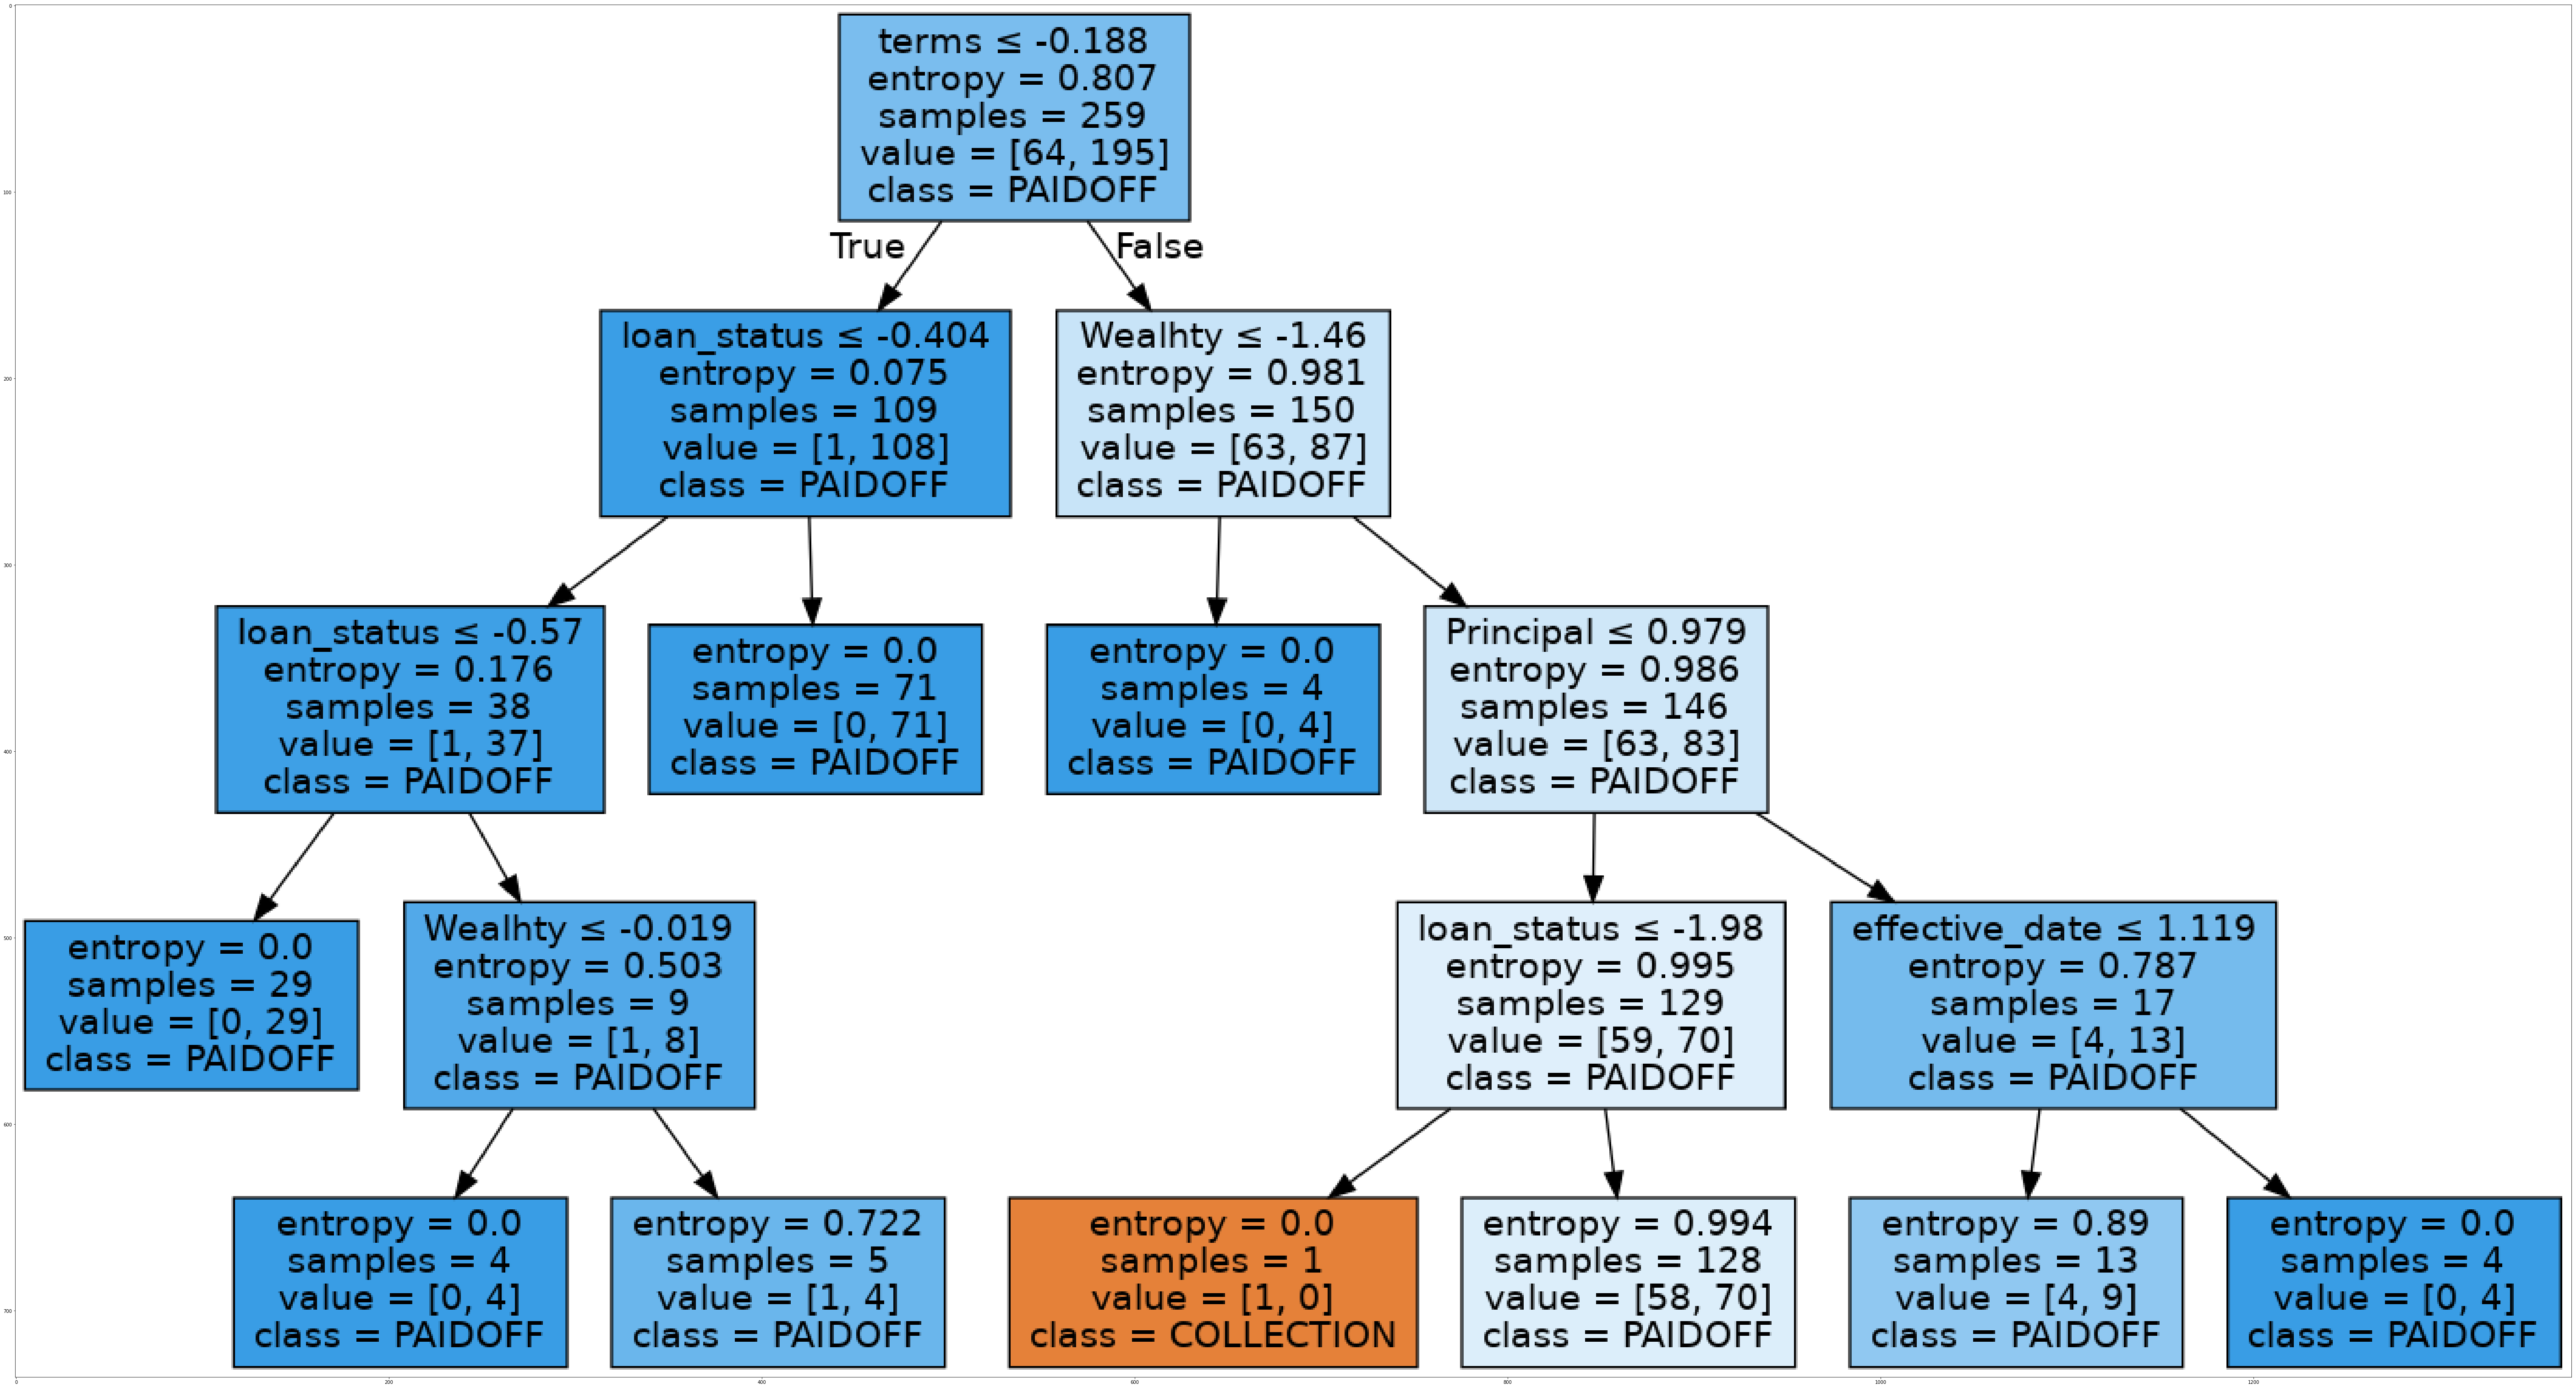

In [30]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline


my_data = Feature
cdf= df.rename(columns={"Unnamed: 0": "Social Group", "Unnamed: 0.1": "Wealhty"})
my_data = cdf
print(my_data[0:5])


dot_data = StringIO()
filename = "loan_status.png"
featureNames = my_data.columns[0:8]
targetNames = my_data["loan_status"].unique().tolist()
out=tree.export_graphviz(loan_status,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine

   Social Group  Wealhty  loan_status  Principal  terms effective_date  \
0             0        0            1       1000     30     2016-09-08   
1             2        2            1       1000     30     2016-09-08   
2             3        3            1       1000     15     2016-09-08   
3             4        4            1       1000     30     2016-09-09   
4             6        6            1       1000     30     2016-09-09   

    due_date  age  education  Gender  dayofweek  weekend  
0 2016-10-07   45          1       0          3        0  
1 2016-10-07   33          0       1          3        0  
2 2016-09-22   27          3       0          3        0  
3 2016-10-08   28          3       1          4        1  
4 2016-10-08   29          3       0          4        1  


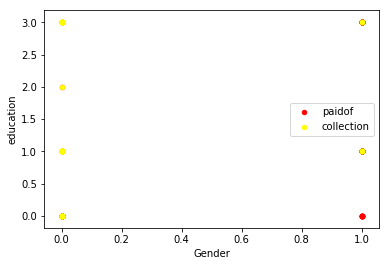

In [32]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
%matplotlib inline 
import matplotlib.pyplot as plt


y= my_data['loan_status']

x= my_data['education']

# a= my_data['effective_date']

# b= my_data['due_date']

labelencoder_y = LabelEncoder()

y = labelencoder_y.fit_transform(y)


labelencoder_x = LabelEncoder()

x = labelencoder_x.fit_transform(x)


# labelencoder_a = LabelEncoder()

# a = labelencoder_a.fit_transform(a)

# labelencoder_b = LabelEncoder()

# b = labelencoder_b.fit_transform(b)




# x= my_data.replace(to_replace= 'PAIDOFF', value= '1')

# a= x.replace(to_replace= 'COLLECTION', value= '0')

my_data['loan_status'] =y
my_data['education'] =x
# a= my_data['effective_date']
# b= my_data['due_date']
# del my_data['education_new']
# del my_data['loan_status new']
print(my_data[0:5])
ax = my_data[my_data['loan_status'] == 1].plot(kind='scatter', x='Gender', y='education', color='Red', label='paidof');
my_data[my_data['loan_status'] == 0].plot(kind='scatter', x='Gender', y='education', color='Yellow', label='collection', ax=ax);
plt.show()

In [33]:
my_data.dtypes
feature_data= my_data[['Social Group', 'Wealhty', 'loan_status', 'Principal', 'terms', 'age', 'education', 'Gender']]

X= np.asarray(feature_data)
X[0:5]

y= np.asarray(feature_data['loan_status'])
y[0:5]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=1)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (259, 8) (259,)
Test set: (87, 8) (87,)


In [34]:
from sklearn import svm
ln = svm.SVC(kernel='rbf')
ln.fit(X_train, y_train) 

yhat = ln.predict(X_test)
yhat [0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([1, 1, 1, 1, 1])

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       1.00      0.05      0.09        22
           1       0.76      1.00      0.86        65

   micro avg       0.76      0.76      0.76        87
   macro avg       0.88      0.52      0.47        87
weighted avg       0.82      0.76      0.67        87

Confusion matrix, without normalization
[[ 1 21]
 [ 0 65]]


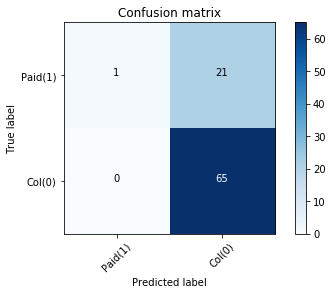

In [36]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Paid(1)','Col(0)'],normalize= False,  title='Confusion matrix')

In [37]:
from sklearn.metrics import f1_score
F1= f1_score(y_test, yhat, average='weighted') 
print("f1_score: %.3f" % F1)

from sklearn.metrics import jaccard_similarity_score
jac= jaccard_similarity_score(y_test, yhat)

print("jaccard_similarity_score: %.3f" % jac)

f1_score: 0.665
jaccard_similarity_score: 0.759


# Logistic Regression

In [38]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

print(my_data.columns)
print(my_data.shape)
my_data['loan_status']= my_data['loan_status'].astype('int')
print(my_data.head())


feature_data= my_data[['Social Group', 'Wealhty', 'loan_status', 'Principal', 'terms', 'age', 'education', 'Gender']]

X= np.asarray(feature_data)
X[0:5]

y= np.asarray(feature_data['loan_status'])
y[0:5]

Index(['Social Group', 'Wealhty', 'loan_status', 'Principal', 'terms',
       'effective_date', 'due_date', 'age', 'education', 'Gender', 'dayofweek',
       'weekend'],
      dtype='object')
(346, 12)
   Social Group  Wealhty  loan_status  Principal  terms effective_date  \
0             0        0            1       1000     30     2016-09-08   
1             2        2            1       1000     30     2016-09-08   
2             3        3            1       1000     15     2016-09-08   
3             4        4            1       1000     30     2016-09-09   
4             6        6            1       1000     30     2016-09-09   

    due_date  age  education  Gender  dayofweek  weekend  
0 2016-10-07   45          1       0          3        0  
1 2016-10-07   33          0       1          3        0  
2 2016-09-22   27          3       0          3        0  
3 2016-10-08   28          3       1          4        1  
4 2016-10-08   29          3       0          4        1  

array([1, 1, 1, 1, 1])

In [39]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]


X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.001, solver='liblinear').fit(X_train,y_train)
print(LR)


yhat = LR.predict(X_test)
print(yhat)


yhat_prob = LR.predict_proba(X_test)


from sklearn.metrics import jaccard_similarity_score
print("\nJaccard Accuracy Score: %.3f" % jaccard_similarity_score(y_test, yhat))

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
[0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1
 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1]

Jaccard Accuracy Score: 0.929


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[[53  5]
 [ 0 12]]
Confusion matrix, without normalization
[[53  5]
 [ 0 12]]
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        12
           1       1.00      0.91      0.95        58

   micro avg       0.93      0.93      0.93        70
   macro avg       0.85      0.96      0.89        70
weighted avg       0.95      0.93      0.93        70


Log Loss : 0.596


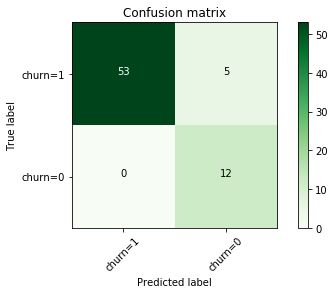

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))



# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')


print (classification_report(y_test, yhat))


from sklearn.metrics import log_loss
print("\nLog Loss : %.3f" % log_loss(y_test, yhat_prob))

# Model Evaluation using Test set

In [41]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [42]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-02-18 09:48:53--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-02-18 09:48:53 (416 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [43]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [44]:
test_df = pd.read_csv('loan_test.csv')
test_df.columns

cdf= test_df.rename(columns={"Unnamed: 0": "Social_Group", "Unnamed: 0.1": "Wealhty"})

a= cdf['loan_status']
b= cdf['due_date']
c= cdf['effective_date']
g= cdf['Gender']
e= cdf['education']


# labeled loan status
labelencoder_a = LabelEncoder()
a = labelencoder_a.fit_transform(a)

# labeled due date
labelencoder_b = LabelEncoder()
b = labelencoder_b.fit_transform(b)

#labeled effective date
labelencoder_c = LabelEncoder()
c = labelencoder_c.fit_transform(c)

# labeled gender
labelencoder_g = LabelEncoder()
g = labelencoder_g.fit_transform(g)


# labeled education
labelencoder_e = LabelEncoder()
e = labelencoder_e.fit_transform(e)

cdf['loan_status']= a
cdf['due_date'] = b
cdf['effective_date'] = c
cdf['Gender'] = g
cdf['education'] = e


X= cdf[['Social_Group', 'Wealhty', 'Principal', 'terms', 'effective_date', 'due_date', 'age', 'education', 'Gender']].values


y= cdf['loan_status']

cdf.head()

,Social_Group,Wealhty,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,1,1000,30,5,5,50,0,0
1,5,5,1,300,7,6,10,35,2,1
2,21,21,1,1000,30,0,7,43,1,0
3,24,24,1,1000,30,0,7,26,3,1
4,35,35,1,800,15,1,14,29,0,1


### KNN-----> F1 and Jaccard Score

In [45]:
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3 , random_state=6)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


k = 7
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)

yhat = neigh.predict(X_test)
print("\nKN Accuracy with K=7 : ", metrics.accuracy_score(y_test, yhat))

jac= jaccard_similarity_score(y_test, yhat)

print("\njaccard_similarity_score: %.3f" % jac)

F1= f1_score(y_test, yhat, average='weighted') 
print("\nf1_score: %.3f" % F1)

Train set: (37, 9) (37,)
Test set: (17, 9) (17,)

KN Accuracy with K=7 :  0.9411764705882353

jaccard_similarity_score: 0.941

f1_score: 0.943


### Decession Tree -----> F1 and Jaccard Score

In [46]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3 , random_state=7)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


loan_status = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

loan_status.fit(X_train, y_train)

prediction= loan_status.predict(X_test)


print("\nDecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, prediction))

F1= f1_score(y_test, yhat, average='weighted') 
print("\nf1_score: %.3f" % F1)


jac= jaccard_similarity_score(y_test, yhat)
print("\njaccard_similarity_score: %.3f" % jac)

Train set: (37, 9) (37,)
Test set: (17, 9) (17,)

DecisionTrees's Accuracy:  0.9411764705882353

f1_score: 0.716

jaccard_similarity_score: 0.706


### SVM ----> F1 and Jaccard Score

In [47]:
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3 , random_state=5)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


ln = svm.SVC(kernel='rbf')
ln.fit(X_train, y_train) 

yhat = ln.predict(X_test)

F1= f1_score(y_test, yhat, average='weighted') 
print("\nf1_score: %.3f" % F1)


jac= jaccard_similarity_score(y_test, yhat)
print("\njaccard_similarity_score: %.3f" % jac)

Train set: (37, 9) (37,)
Test set: (17, 9) (17,)

f1_score: 0.584

jaccard_similarity_score: 0.706


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Logistic Regression F1, Jaccard and Log loss scores

In [48]:
from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_similarity_score

X = preprocessing.StandardScaler().fit(X).transform(X)
print(X[0:5])

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3 , random_state=8)
print ('\nTrain set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

LR = LogisticRegression(C=0.001, solver='liblinear').fit(X_train,y_train)
yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)



print("\nJaccard Accuracy Score: %.3f" % jaccard_similarity_score(y_test, yhat))
F1= f1_score(y_test, yhat, average='weighted') 
print("\nF1_score: %.3f" % F1)

print("\nLog Loss : %.3f" % log_loss(y_test, yhat_prob))

[[-1.58 -1.58  0.49  0.93  2.52 -0.46  3.06 -1.5  -1.98]
 [-1.54 -1.54 -3.56 -1.7   3.25  0.42  0.53  0.22  0.51]
 [-1.4  -1.4   0.49  0.93 -1.18 -0.11  1.88 -0.64 -1.98]
 [-1.38 -1.38  0.49  0.93 -1.18 -0.11 -0.98  1.09  0.51]
 [-1.28 -1.28 -0.67 -0.79 -0.44  1.12 -0.48 -1.5   0.51]]

Train set: (37, 9) (37,)
Test set: (17, 9) (17,)

Jaccard Accuracy Score: 0.882

F1_score: 0.889

Log Loss : 0.683


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard     | F1-score     | LogLoss |
|--------------------|-------------|--------------|---------|
| KNN                | 0.941       | 0.943        | NA      |
| Decision Tree      | 0.706       | 0.716        | NA      |
| SVM                | 0.706       | 0.584        | NA      |
| LogisticRegression | 0.882       | 0.889        | 0.683   |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>